In [196]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('/Users/nissani/Desktop/Hateful_Memes_Project/data/train.json', 'r') as f:
    train_data = json.load(f)
    
with open('/Users/nissani/Desktop/Hateful_Memes_Project/data/dev.json', 'r') as f:
    dev_data = json.load(f)

In [3]:
hateful = 0
not_hateful = 0
for el in list(train_data.keys()):
    if train_data[el]['label'] == 1:
        hateful += 1
    else:
        not_hateful += 1

print('Hateful: {}'.format(hateful))
print('Not Hateful: {}'.format(not_hateful))

hateful = 0
not_hateful = 0
for el in list(dev_data.keys()):
    if dev_data[el]['label'] == 1:
        hateful += 1
    else:
        not_hateful += 1

print('Hateful: {}'.format(hateful))
print('Not Hateful: {}'.format(not_hateful))

Hateful: 3050
Not Hateful: 5450
Hateful: 250
Not Hateful: 250


In [4]:
columns = []
for el in list(train_data['42953'].keys())[6:]:
    if el != 'emotion_feature':
        columns.append(el)

In [61]:
columns.remove('all_text_freq')

In [62]:
columns

['meme_hate_speech',
 'meme_offensive_language',
 'meme_neither',
 'caption_hate_speech',
 'caption_offensive_language',
 'caption_neither',
 'tag_hate_speech',
 'tag_offensive_language',
 'tag_neither',
 'meme_sentiment',
 'caption_sentiment',
 'tag_sentiment',
 'tag_feature_vector',
 'caption_feature_vector',
 'meme_feature_vector',
 'protected_meme_scores',
 'protected_caption_scores',
 'train_text_freq',
 'dev_text_freq',
 'test_text_freq',
 'tags_race',
 'tags_disability',
 'tags_religion',
 'tags_sexual_orientation',
 'tags_violence',
 'tags_criminals',
 'tags_gender',
 'tags_animals',
 'text_race',
 'text_disability',
 'text_religion',
 'text_sexual_orientation',
 'text_violence',
 'text_criminals',
 'text_gender',
 'text_animals']

In [85]:
new_columns = ['tag_feature_vector', 'caption_feature_vector', 'meme_feature_vector']

In [63]:
train_data['42953']['tag_sentiment']

['NEGATIVE', 0.9568]

In [64]:
def sentiment_check(data):
    sentiment_list = data
    sentiment_scores = {}
    if sentiment_list[0] == 'NEGATIVE':
        sentiment_scores['negative'] = sentiment_list[1]
        sentiment_scores['positive'] = 1 - sentiment_list[1]
    elif sentiment_list[0] == 'POSITIVE':
        sentiment_scores['positive'] = sentiment_list[1]
        sentiment_scores['negative'] = 1 - sentiment_list[1]
    else:
        raise Exception("sentiment label not found")
    
    return sentiment_scores

In [65]:
train_data['42953']['protected_meme_scores']

[567.9492130065482,
 546.2337104679173,
 588.6687470631587,
 571.2920274632197,
 555.7372433059063,
 553.8820845654845,
 555.1955790296342,
 588.4936292130878,
 584.0770774830744]

In [66]:
def format_data(data, keys1, keys2):
    labels = []
    feature_vectors = []
    for key1 in keys1:
        labels.append(data[key1]['label'])
        feature_vector = []
        for key2 in keys2:
            if isinstance(data[key1][key2], list):
                if 'sentiment' in key2:
                    sentiment_scores = sentiment_check(data[key1][key2])
                    feature_vector.append(sentiment_scores['negative'])
                    feature_vector.append(sentiment_scores['positive'])
                else:
                    for el in data[key1][key2]:
                        feature_vector.append(el)
            else:
                feature_vector.append(data[key1][key2])
        feature_vectors.append(feature_vector)
        
    return labels, feature_vectors

In [86]:
train_labels, train_feature_vectors = format_data(train_data, list(train_data.keys()), new_columns)
dev_labels, dev_feature_vectors = format_data(dev_data, list(dev_data.keys()), new_columns)

In [87]:
len(train_feature_vectors[0])

1836

In [174]:
PCA_model = PCA(n_components = 500)
reduced_train_feature_vectors = PCA_model.fit_transform(train_feature_vectors)
reduced_dev_feature_vectors = PCA_model.transform(dev_feature_vectors)
components = PCA_model.components_

In [175]:
print(sum(PCA_model.explained_variance_ratio_))

0.950957689649559


In [176]:
print(PCA_model.singular_values_)

[415.28464968 392.00610309 375.45097992 358.43862168 336.77869796
 325.61972752 318.50838871 303.96412266 296.32293861 292.50437024
 279.46952487 278.79680343 275.52616386 265.70075647 264.18291974
 256.08369858 245.04478752 243.01532897 239.65008122 235.99261549
 232.85230243 232.66878654 227.06588399 222.39198962 218.56687206
 213.88897746 211.3183953  209.79508975 207.62635168 204.22007817
 201.92953764 199.14097119 197.35943299 196.59057309 194.95006509
 191.44024397 189.90831446 186.87659476 185.13475772 183.47004093
 181.15357747 179.64494893 177.13704348 176.35882829 173.55495549
 171.09084036 168.50547926 165.66945839 164.26025203 163.69370219
 161.25358039 160.10440539 157.62210853 155.99209437 154.72736297
 153.797771   152.22688693 149.7711539  147.75450094 147.110372
 145.29647197 143.88071148 143.4849338  143.01061905 141.59711868
 140.35808815 137.46169433 136.7116511  133.41993009 132.90663151
 131.8776782  131.00357661 128.11062112 127.1125113  126.223483
 125.90334737 

In [177]:
lr = LogisticRegression()
lr.fit(reduced_train_feature_vectors, train_labels)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [178]:
lr.score(reduced_train_feature_vectors, train_labels)

0.7325882352941177

In [179]:
lr.score(reduced_dev_feature_vectors, dev_labels)

0.544

In [201]:
predictions = lr.predict_proba(reduced_train_feature_vectors)
roc_auc_score(train_labels, predictions[:,1])

0.7851199879681154

In [194]:
predictions = lr.predict_proba(reduced_dev_feature_vectors)
roc_auc_score(dev_labels, predictions[:,1])

0.608608

In [202]:
# calculate precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(train_labels, predictions[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

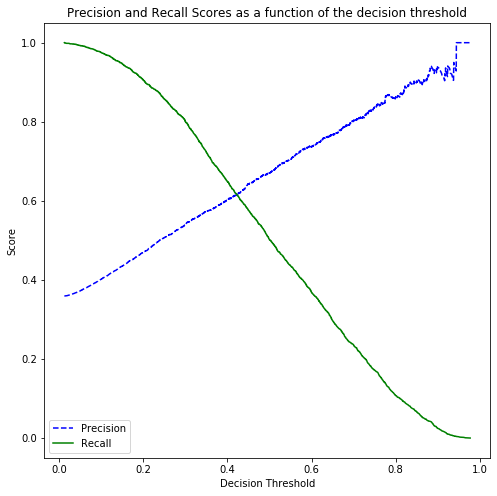

In [203]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [144]:
knn = KNN()

In [159]:
knn.fit(reduced_dev_feature_vectors, dev_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [160]:
knn.score(reduced_train_feature_vectors, train_labels)

0.5338823529411765

In [161]:
knn.score(reduced_dev_feature_vectors, dev_labels)

0.608

In [148]:
model = xgb.XGBClassifier()

In [162]:
model.fit(np.array(reduced_dev_feature_vectors), np.array(dev_labels))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [163]:
model.score(np.array(reduced_train_feature_vectors), np.array(train_labels))

0.536

In [164]:
model.score(np.array(reduced_dev_feature_vectors), np.array(dev_labels))

1.0

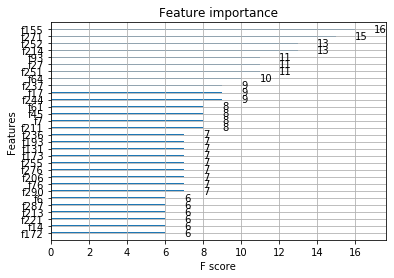

In [165]:
xgb.plot_importance(model, max_num_features = 30)

In [166]:
len(train_feature_vectors[0])

1836

In [167]:
columns

['meme_hate_speech',
 'meme_offensive_language',
 'meme_neither',
 'caption_hate_speech',
 'caption_offensive_language',
 'caption_neither',
 'tag_hate_speech',
 'tag_offensive_language',
 'tag_neither',
 'meme_sentiment',
 'caption_sentiment',
 'tag_sentiment',
 'tag_feature_vector',
 'caption_feature_vector',
 'meme_feature_vector',
 'protected_meme_scores',
 'protected_caption_scores',
 'train_text_freq',
 'dev_text_freq',
 'test_text_freq',
 'tags_race',
 'tags_disability',
 'tags_religion',
 'tags_sexual_orientation',
 'tags_violence',
 'tags_criminals',
 'tags_gender',
 'tags_animals',
 'text_race',
 'text_disability',
 'text_religion',
 'text_sexual_orientation',
 'text_violence',
 'text_criminals',
 'text_gender',
 'text_animals']

In [172]:
predictions = knn.predict(reduced_train_feature_vectors)
hateful = 0
not_hateful = 0
for el in predictions:
    if el == 1:
        hateful += 1
    else:
        not_hateful += 1

print('Hateful: {}'.format(hateful))
print('Not Hateful: {}'.format(not_hateful))

Hateful: 4546
Not Hateful: 3954


In [25]:
def ablation_experiment(train_data, dev_data, keys2, model):
    remaining_keys = keys2.copy()
    while len(remaining_keys) > 0:
        scores = []
        print('getting scores')
        for name in remaining_keys:
            current_keys = remaining_keys.copy()
            current_keys.remove(name)
            print('making keys')
            train_labels, train_feature_vectors = format_data(train_data, list(train_data.keys()), current_keys)
            dev_labels, dev_feature_vectors = format_data(dev_data, list(dev_data.keys()), current_keys)
            print('formatted_data')
            model.fit(np.array(train_feature_vectors), np.array(train_labels))
            scores.append(model.score(np.array(dev_feature_vectors), np.array(dev_labels)))
            print(name)
            print(scores[-1])
        min_score = min(scores)
        print(min_score)
        argmin_score = np.argmin(scores)
        print(remaining_keys[argmin_score])
        remaining_keys.remove(remaining_keys[argmin_score])
    

In [26]:
ablation_experiment(train_data, dev_data, columns, model)

getting scores
making keys
formatted_data
meme_hate_speech
0.528
making keys
formatted_data
meme_offensive_language
0.526
making keys
formatted_data
meme_neither
0.526
making keys
formatted_data
caption_hate_speech
0.53
making keys
formatted_data
caption_offensive_language
0.53
making keys
formatted_data
caption_neither
0.528
making keys
formatted_data
tag_hate_speech
0.526
making keys
formatted_data
tag_offensive_language
0.524
making keys
formatted_data
tag_neither
0.528
making keys
formatted_data
meme_sentiment
0.518
making keys
formatted_data
caption_sentiment
0.528
making keys
formatted_data
tag_sentiment
0.53
making keys
formatted_data


KeyboardInterrupt: 

In [ ]:
#remaining_keys=keys2.copy()
#while len(remaining_keys) > 0
#   worst_score=???
#.  associated_key=X
# for i in len(keys2):
#     current_keys=key2.copy()
#     cirrent_keys.remove(key2[i])
#      score=pickle_rick(remaining_keys)
#

In [ ]:
#[1,2,3,a,v]
#[1,2,3,4,5]


#t=0
#[1,2,3]
#t=1
#[2,3,a]
#t=2
#